In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [2]:
# Load hyperspectral image
data_mat = sio.loadmat('/content/PaviaU.mat')

groundtruth_mat = sio.loadmat('/content/PaviaU_gt.mat')

# Extract data and labels
X = data_mat['paviaU']  # (145, 145, 200)
y = groundtruth_mat['paviaU_gt']  # (145, 145)

# Print shape
print(f"Original Data Shape: {X.shape}")  # (145, 145, 200)
print(f"Ground Truth Shape: {y.shape}")   # (145, 145)


Original Data Shape: (610, 340, 103)
Ground Truth Shape: (610, 340)


In [4]:
# Reshape for PCA
X_reshaped = X.reshape(-1, 103)  # (145*145, 200)

# Apply PCA
pca = PCA(n_components=50, whiten=True)  # Reduce to 50 bands
X_pca = pca.fit_transform(X_reshaped)  # (10249, 50)

# Reshape back to spatial dimensions
X_pca = X_pca.reshape(610,340 , 50)

print(f"PCA Reduced Shape: {X_pca.shape}")  # (145, 145, 50)


PCA Reduced Shape: (610, 340, 50)


In [10]:
# Function to extract patches
def create_patches(X, y, patch_size=7):
    half = patch_size // 2
    padded_X = np.pad(X, ((half, half), (half, half), (0, 0)), mode='constant')

    X_patches, y_patches = [], []
    for i in range(half, 610 + half):
        for j in range(half, 340 + half):
            if y[i - half, j - half] != 0:  # Ignore background
                patch = padded_X[i - half:i + half + 1, j - half:j + half + 1, :]
                X_patches.append(patch)
                y_patches.append(y[i - half, j - half])

    return np.array(X_patches), np.array(y_patches)

X_patches, y_patches = create_patches(X_pca, y)

# Reshape X for CNN
X_patches = X_patches.reshape(-1, 7, 7, 50, 1)  # Add channel dimension

print(f"Patches Shape: {X_patches.shape}")  # (num_samples, 7, 7, 50, 1)
print(f"Labels Shape: {y_patches.shape}")  # (num_samples,)


Patches Shape: (42776, 7, 7, 50, 1)
Labels Shape: (42776,)


In [11]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_patches)  # Convert to 0-15

# One-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = one_hot_encoder.fit_transform(y_encoded.reshape(-1, 1))

print(f"One-Hot Encoded Labels Shape: {y_onehot.shape}")  # (num_samples, 16)


One-Hot Encoded Labels Shape: (42776, 9)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_patches, y_onehot, test_size=0.3, random_state=42)

print(f"Training Data Shape: {X_train.shape}")  # (num_train, 7, 7, 50, 1)
print(f"Testing Data Shape: {X_test.shape}")   # (num_test, 7, 7, 50, 1)


Training Data Shape: (29943, 7, 7, 50, 1)
Testing Data Shape: (12833, 7, 7, 50, 1)


In [13]:
# Define 2D CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(7, 7, 50)),  # Fixed input shape
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.6),
    Dense(9, activation='softmax')  # 16 classes
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 7, 7, 32)            │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,961 (195.16 KB)

 Trainable params: 49,961 (195.16 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)


Epoch 1/20
936/936 - 12s - 13ms/step - accuracy: 0.8780 - loss: 0.3553 - val_accuracy: 0.9912 - val_loss: 0.0310
Epoch 2/20
936/936 - 4s - 4ms/step - accuracy: 0.9759 - loss: 0.0722 - val_accuracy: 0.9944 - val_loss: 0.0166
Epoch 3/20
936/936 - 6s - 6ms/step - accuracy: 0.9870 - loss: 0.0374 - val_accuracy: 0.9952 - val_loss: 0.0169
Epoch 4/20
936/936 - 3s - 3ms/step - accuracy: 0.9921 - loss: 0.0230 - val_accuracy: 0.9993 - val_loss: 0.0019
Epoch 5/20
936/936 - 5s - 5ms/step - accuracy: 0.9921 - loss: 0.0259 - val_accuracy: 0.9990 - val_loss: 0.0032
Epoch 6/20
936/936 - 4s - 4ms/step - accuracy: 0.9927 - loss: 0.0225 - val_accuracy: 0.9988 - val_loss: 0.0048
Epoch 7/20
936/936 - 4s - 5ms/step - accuracy: 0.9946 - loss: 0.0153 - val_accuracy: 0.9988 - val_loss: 0.0038
Epoch 8/20
936/936 - 5s - 5ms/step - accuracy: 0.9952 - loss: 0.0143 - val_accuracy: 0.9995 - val_loss: 7.7876e-04
Epoch 9/20
936/936 - 3s - 4ms/step - accuracy: 0.9945 - loss: 0.0190 - val_accuracy: 0.9995 - val_loss: 0.

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


402/402 - 1s - 2ms/step - accuracy: 0.9918 - loss: 0.0970
Test Accuracy: 0.9918


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


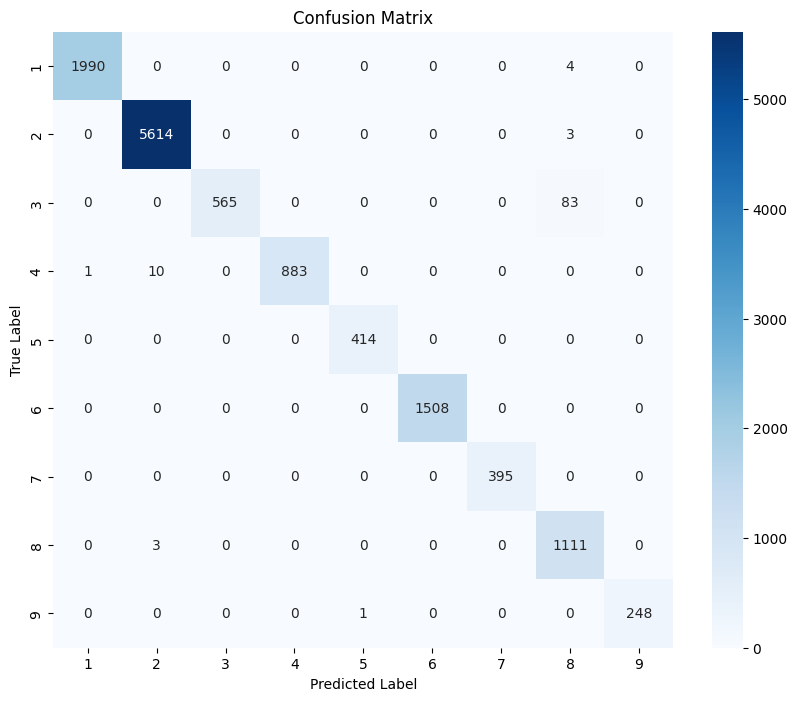

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


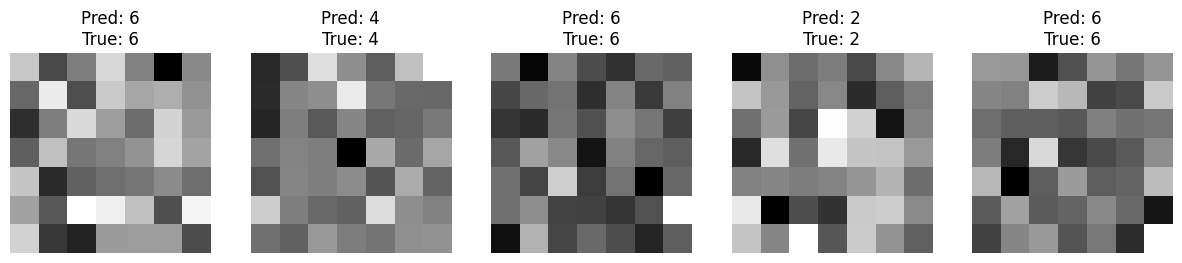

In [18]:
import random

# Pick random test samples
indices = random.sample(range(len(X_test)), 5)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx, :, :, 25, 0], cmap='gray')  # Show the middle PCA band
    plt.title(f"Pred: {y_pred_classes[idx] + 1}\nTrue: {y_true_classes[idx] + 1}")
    plt.axis('off')

plt.show()


In [19]:
from sklearn.metrics import classification_report

# Compute and display precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1994
           1       1.00      1.00      1.00      5617
           2       1.00      0.87      0.93       648
           3       1.00      0.99      0.99       894
           4       1.00      1.00      1.00       414
           5       1.00      1.00      1.00      1508
           6       1.00      1.00      1.00       395
           7       0.93      1.00      0.96      1114
           8       1.00      1.00      1.00       249

    accuracy                           0.99     12833
   macro avg       0.99      0.98      0.99     12833
weighted avg       0.99      0.99      0.99     12833

